In [1]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial6_jax"

print("Device:", jax.devices()[0])

<ipython-input-1-a7256833b97d>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: gpu:0


<Figure size 640x480 with 0 Axes>

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

What is attention? 

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

In [4]:
seq_len, d_k = 3, 2
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 [[-0.6613315   0.70056266]
 [ 0.08239268 -1.7793142 ]
 [-0.04378588  1.0965251 ]]
K
 [[ 1.7257481   0.35568172]
 [ 1.3034704   1.2873708 ]
 [ 1.6871481  -0.5714404 ]]
V
 [[ 1.5129997   1.1050899 ]
 [ 0.27949408 -0.46224892]
 [-1.1003422  -1.1437942 ]]
Values
 [[ 0.376226   -0.14656176]
 [-0.42778552 -0.5989564 ]
 [ 0.4362476  -0.11678296]]
Attention
 [[0.27963293 0.54049295 0.17987415]
 [0.22194655 0.06706189 0.71099156]
 [0.27977085 0.58373076 0.13649833]]


In [5]:
class MultiheadAttention(nn.Module):
    embed_dim : int  # Output dimension
    num_heads : int  # Number of parallel heads (h)

    def setup(self):
        # Stack all weight matrices 1...h and W^Q, W^K, W^V together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Dense(3*self.embed_dim,
                                 kernel_init=nn.initializers.xavier_uniform(),  # Weights with Xavier uniform init
                                 bias_init=nn.initializers.zeros  # Bias init with zeros
                                )
        self.o_proj = nn.Dense(self.embed_dim,
                               kernel_init=nn.initializers.xavier_uniform(),
                               bias_init=nn.initializers.zeros)

    def __call__(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.shape
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.transpose(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o, attention

In [6]:
## Test MultiheadAttention implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embed_dim=128, num_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({'params': params}, x)
print('Out', out.shape, 'Attention', attn.shape)

del mh_attn, params

Out (3, 16, 128) Attention (3, 4, 16, 16)


Transformer Encoder

In [7]:
class EncoderBlock(nn.Module):
    input_dim : int  # Input dimension is needed here since it is equal to the output dimension (residual connection)
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        # Attention layer
        self.self_attn = MultiheadAttention(embed_dim=self.input_dim,
                                            num_heads=self.num_heads)
        # Two-layer MLP
        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim)
        ]
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)

    def __call__(self, x, mask=None, train=True):
        # Attention part
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic=not train)
        x = self.norm1(x)

        # MLP part
        linear_out = x
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        x = self.norm2(x)

        return x

In [8]:
## Test EncoderBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = EncoderBlock(input_dim=128, num_heads=4, dim_feedforward=512, dropout_prob=0.1)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

Out (3, 16, 128)


In [9]:
class TransformerEncoder(nn.Module):
    num_layers : int
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]

    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x

    def get_attention_maps(self, x, mask=None, train=True):
        # A function to return the attention maps within the model for a single application
        # Used for visualization purpose later
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [10]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(num_layers=5,
                              input_dim=128,
                              num_heads=4,
                              dim_feedforward=256,
                              dropout_prob=0.15)
# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


In [11]:
class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int = 5000  # Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

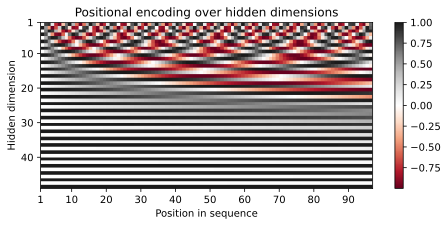

In [12]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(d_model=48, max_len=96).bind({})
# Obtain positional encodings as numpy array
pe = jax.device_get(encod_block.pe.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

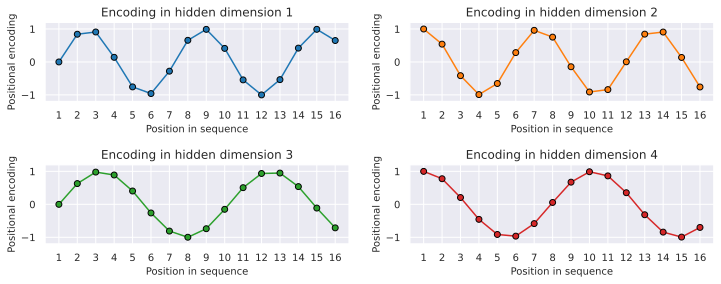

In [13]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [14]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

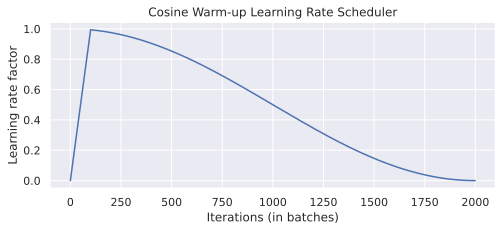

In [15]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [16]:
class TransformerPredictor(nn.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_classes : int                 # Number of classes to predict per sequence element
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        # Input dim -> Model dim
        self.input_dropout = nn.Dropout(self.input_dropout_prob)
        self.input_layer = nn.Dense(self.model_dim)
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(self.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.model_dim,
                                              dim_feedforward=2*self.model_dim,
                                              num_heads=self.num_heads,
                                              dropout_prob=self.dropout_prob)
        # Output classifier per sequence lement
        self.output_net = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.num_classes)
        ]

    def __call__(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask, train=train)
        for l in self.output_net:
            x = l(x) if not isinstance(l, nn.Dropout) else l(x, deterministic=not train)
        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps

In [17]:
## Test TransformerPredictor implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
# Create Transformer encoder
transpre = TransformerPredictor(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)
# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, binded_mod, params

Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


In [18]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)

    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [19]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

In [20]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(10000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

In [21]:
inp_data, labels = rev_train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: [0 7 6 4 4 8 0 6 2 0 5 9 7 7 7 7]
Labels:     [7 7 7 7 9 5 0 2 6 0 8 4 4 6 7 0]


In [22]:
class ReverseTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _ = batch
        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        return calculate_loss

In [23]:
def train_reverse(max_epochs=10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = ReverseTrainer(model_name='ReverseTask',
                             exmp_batch=next(iter(rev_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [24]:
reverse_trainer, reverse_result = train_reverse(model_dim=32,
                                                num_heads=1,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                dropout_prob=0.0,
                                                lr=5e-4,
                                                warmup=50)

In [25]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


In [26]:
data_input, labels = next(iter(rev_val_loader))
inp_data = jax.nn.one_hot(data_input, num_classes=reverse_trainer.model.num_classes)
attention_maps = reverse_trainer.model_bd.get_attention_maps(inp_data)

In [27]:
attention_maps[0].shape

(128, 1, 16, 16)

In [28]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

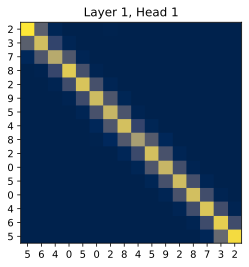

In [29]:
plot_attention_maps(data_input, attention_maps, idx=0)

###### Set Anomaly Detection (Very Cool experiment with Transformers)

In [30]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = img / 255.   # Normalization is done in the ResNet
    return img

# Resize to 224x224, and map to JAX
transform = transforms.Compose([transforms.Resize((224,224)),
                                image_to_numpy
                               ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

# For later, keep a dictionary mapping class indices to class names
class_idx_to_name = {val: key for key, val in train_set.class_to_idx.items()}

100%|██████████| 169001437/169001437 [00:01<00:00, 87098972.46it/s] 


Extracting ../../data/cifar-100-python.tar.gz to ../../data
Files already downloaded and verified


Transformers are not translation of CNN, which is why, we have to extract the high dimensional features through a CNN network

In [31]:
# Import and install flaxmodels if needed
try:
    import flaxmodels
except ModuleNotFoundError:
    !pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
    import flaxmodels

# Pretrained ResNet34 on ImageNet
resnet34 = flaxmodels.ResNet34(output='activations', pretrained='imagenet', normalize=True)
main_rng, resnet_rng = random.split(main_rng, 2)
resnet_params = resnet34.init(resnet_rng, jnp.zeros((1, 224, 224, 3)))
# Jit its forward pass for efficiency
apply_resnet = jax.jit(lambda imgs: resnet34.apply(resnet_params, imgs, train=False))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-5gvvvwqn
  Running command git clone --filter=blob:none --quiet https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-5gvvvwqn
  Resolved https://github.com/matthias-wright/flaxmodels.git to commit e928be7e14d0eb1f39100ff99e6d0fa4e64b412d
  Preparing metadata (setup.py) ... done
  Created wheel for flaxmodels: filename=flaxmodels-0.1.2-py3-none-any.whl size=115720 sha256=c6fab985f0d7b2c18ca7a68b7b0d8905d7739740f3476d4b35129807ed9e9097
  Stored in directory: /tmp/pip-ephem-wheel-cache-lxhlskvf/wheels/ab/a2/10/fb1e13191f4f2affb55f58d99a731ca19e6aa4a58215a1b235
Successfully built flaxmodels


Downloading: "https://www.dropbox.com/s/rnqn2x6trnztg4c/resnet34_weights.h5" to /tmp/flaxmodels/resnet34_weights.h5


100%|██████████| 87.4M/87.4M [00:01<00:00, 55.3MiB/s]


In [32]:
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False,
                                      collate_fn=lambda batch: np.stack([b[0] for b in batch], axis=0))
        extracted_features = []
        for imgs in tqdm(data_loader):
            feats = apply_resnet(imgs)
            # Average pooling on the last conv features to obtain a image-level feature vector
            feats = feats['block4_2'].mean(axis=(1,2))
            extracted_features.append(feats)
        extracted_features = jnp.concatenate(extracted_features, axis=0)
        extracted_features = jax.device_get(extracted_features)
        np.savez_compressed(save_file, feats=extracted_features)
    else:
        extracted_features = np.load(save_file)['feats']
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.npz")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.npz")
test_feats = extract_features(test_set, test_feat_file)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [33]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: (50000, 512)
Test:  (10000, 512)


In [34]:
## Split train into train+val
# Get labels from train set
labels = np.array(train_set.targets, dtype=np.int32)

# Get indices of images per class
num_labels = labels.max()+1
sorted_indices = np.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [35]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, np_rng, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.np_rng = np_rng
        self.set_size = set_size-1  # The set size is here the number of images from the same class per set
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = np.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()

    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = np.stack(test_sets, axis=0)
        return test_sets

    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = self.np_rng.integers(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = self.np_rng.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices

    def __len__(self):
        return self.img_feats.shape[0]

    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = np.concatenate([self.img_feats[img_indices], anomaly[None]], axis=0)
        indices = np.concatenate([img_indices, np.array([idx], dtype=np.int32)], axis=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

In [36]:
SET_SIZE = 10
test_labels = np.array(test_set.targets, dtype=np.int32)

anom_train_dataset = SetAnomalyDataset(train_feats, train_labels, np_rng=np.random.default_rng(42), set_size=SET_SIZE, train=True)
anom_val_dataset   = SetAnomalyDataset(val_feats,   val_labels,   np_rng=np.random.default_rng(43), set_size=SET_SIZE, train=False)
anom_test_dataset  = SetAnomalyDataset(test_feats,  test_labels,  np_rng=np.random.default_rng(123), set_size=SET_SIZE, train=False)

anom_train_loader = data.DataLoader(anom_train_dataset, batch_size=64, shuffle=True,  drop_last=True,  collate_fn=numpy_collate)
anom_val_loader   = data.DataLoader(anom_val_dataset,   batch_size=64, shuffle=False, drop_last=False, collate_fn=numpy_collate)
anom_test_loader  = data.DataLoader(anom_test_dataset,  batch_size=64, shuffle=False, drop_last=False, collate_fn=numpy_collate)

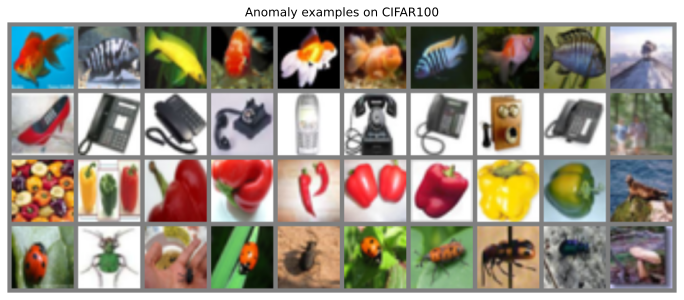

In [37]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = jax.device_get(jnp.stack(images, axis=0)).astype(np.float32)
    images = torch.from_numpy(images)
    images = images.permute(0, 3, 1, 2)
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(anom_test_loader))
visualize_exmp(indices[:4], test_set)


In [38]:
class AnomalyTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _, _ = batch
        return inp_data

    def get_loss_function(self):
        # Function for calculating loss and accuracy for a batch
        def calculate_loss(params, rng, batch, train):
            inp_data, _, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data,
                                      add_positional_encoding=False,  # No positional encoding since this is a permutation equivariant task
                                      train=train,
                                      rngs={'dropout': dropout_apply_rng})
            logits = logits.squeeze(axis=-1)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).astype(jnp.float32).mean()
            return loss, (acc, rng)
        return calculate_loss

In [39]:
def train_anomaly(max_epochs=100, **model_args):
    num_train_iters = len(anom_train_loader) * max_epochs
    # Create a trainer module with specified hyperparameters
    trainer = AnomalyTrainer(model_name='SetAnomalyTask',
                             exmp_batch=next(iter(anom_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(anom_train_loader, anom_val_loader, num_epochs=max_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    train_acc = trainer.eval_model(anom_train_loader)
    val_acc = trainer.eval_model(anom_val_loader)
    test_acc = trainer.eval_model(anom_test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}

In [40]:
anomaly_trainer, anomaly_result = train_anomaly(model_dim=256,
                                                num_heads=4,
                                                num_classes=1,
                                                num_layers=4,
                                                dropout_prob=0.1,
                                                input_dropout_prob=0.1,
                                                lr=5e-4,
                                                warmup=100)

In [41]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 98.33%
Val accuracy:   94.50%
Test accuracy:  94.66%


In [42]:
inp_data, indices, labels = next(iter(anom_test_loader))
preds = anomaly_trainer.model_bd(inp_data, add_positional_encoding=False, train=False)
preds = jax.nn.softmax(preds.squeeze(axis=-1))

permut = np.random.permutation(inp_data.shape[1])
permut_inp_data = inp_data[:,permut]
perm_preds = anomaly_trainer.model_bd(permut_inp_data, add_positional_encoding=False, train=False)
perm_preds = jax.nn.softmax(perm_preds.squeeze(axis=-1))

preds = jax.device_get(preds)
perm_preds = jax.device_get(perm_preds)

assert np.abs(preds[:,permut] - perm_preds).max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut])
print("Permuted preds\n", perm_preds[0])

Preds
 [4.8264596e-08 2.7709259e-08 5.5641070e-08 1.4563341e-08 4.3522910e-08
 1.2441276e-08 1.3902196e-07 3.5155960e-08 9.9999952e-01 5.2554757e-08]
Permuted preds
 [4.82645994e-08 2.77092607e-08 5.56410740e-08 1.45633425e-08
 4.35229168e-08 1.24412773e-08 1.39021992e-07 3.51559635e-08
 9.99999642e-01 5.25548636e-08]


In [43]:
attention_maps = anomaly_trainer.model_bd.get_attention_maps(inp_data, add_positional_encoding=False, train=False)
predictions = preds.argmax(axis=-1)

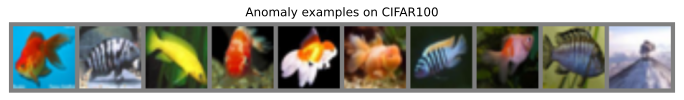

Main class: aquarium_fish, Anomaly class: mountain
Prediction: image 9


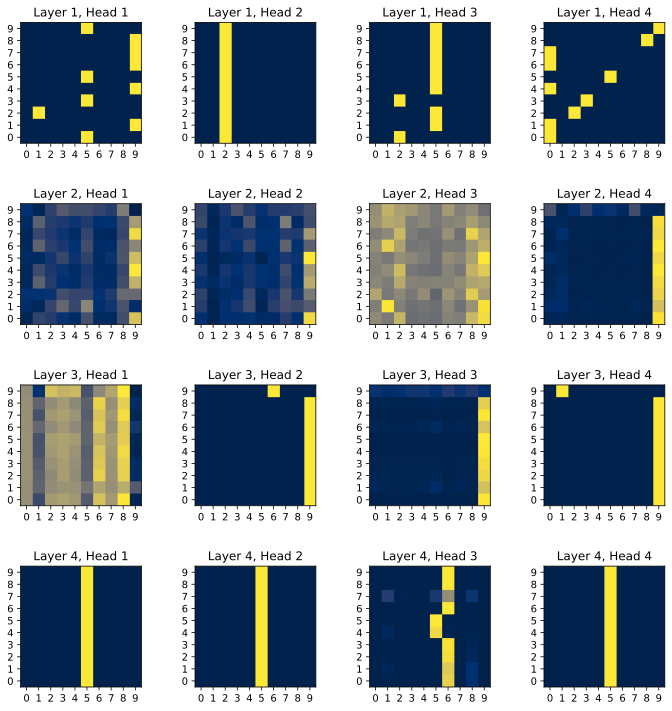

In [44]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print(f'Main class: {class_idx_to_name[test_labels[indices[idx,0]]]}, Anomaly class: {class_idx_to_name[test_labels[indices[idx,-1]]]}')
    print(f'Prediction: image {predictions[idx].item()}')
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

In [45]:
mistakes = np.where(predictions != 9)[0]
print("Indices with mistake:", mistakes)

Indices with mistake: [10 58]


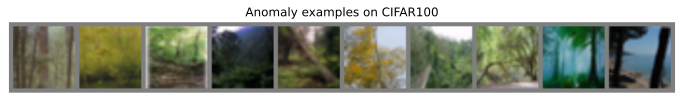

Main class: forest, Anomaly class: sea
Prediction: image 3


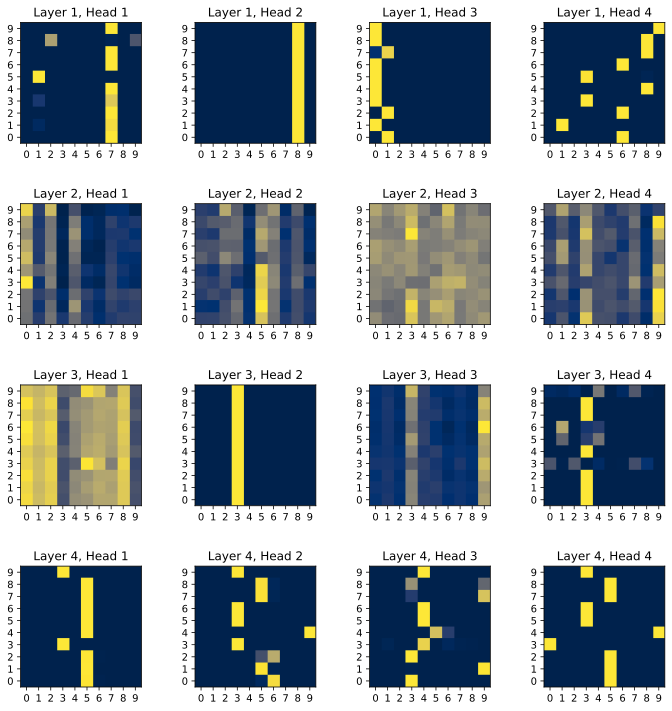

Probabilities:
Image 0: 0.84%
Image 1: 1.53%
Image 2: 1.00%
Image 3: 54.88%
Image 4: 2.39%
Image 5: 6.54%
Image 6: 4.91%
Image 7: 1.44%
Image 8: 1.39%
Image 9: 25.09%


In [46]:
visualize_prediction(mistakes[0])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[0]]):
    print(f"Image {i}: {100.0*p:4.2f}%")